In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

mkl.set_num_threads(4)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [3]:
def append_ones(matrix, axis=1):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

# MNIST dataset

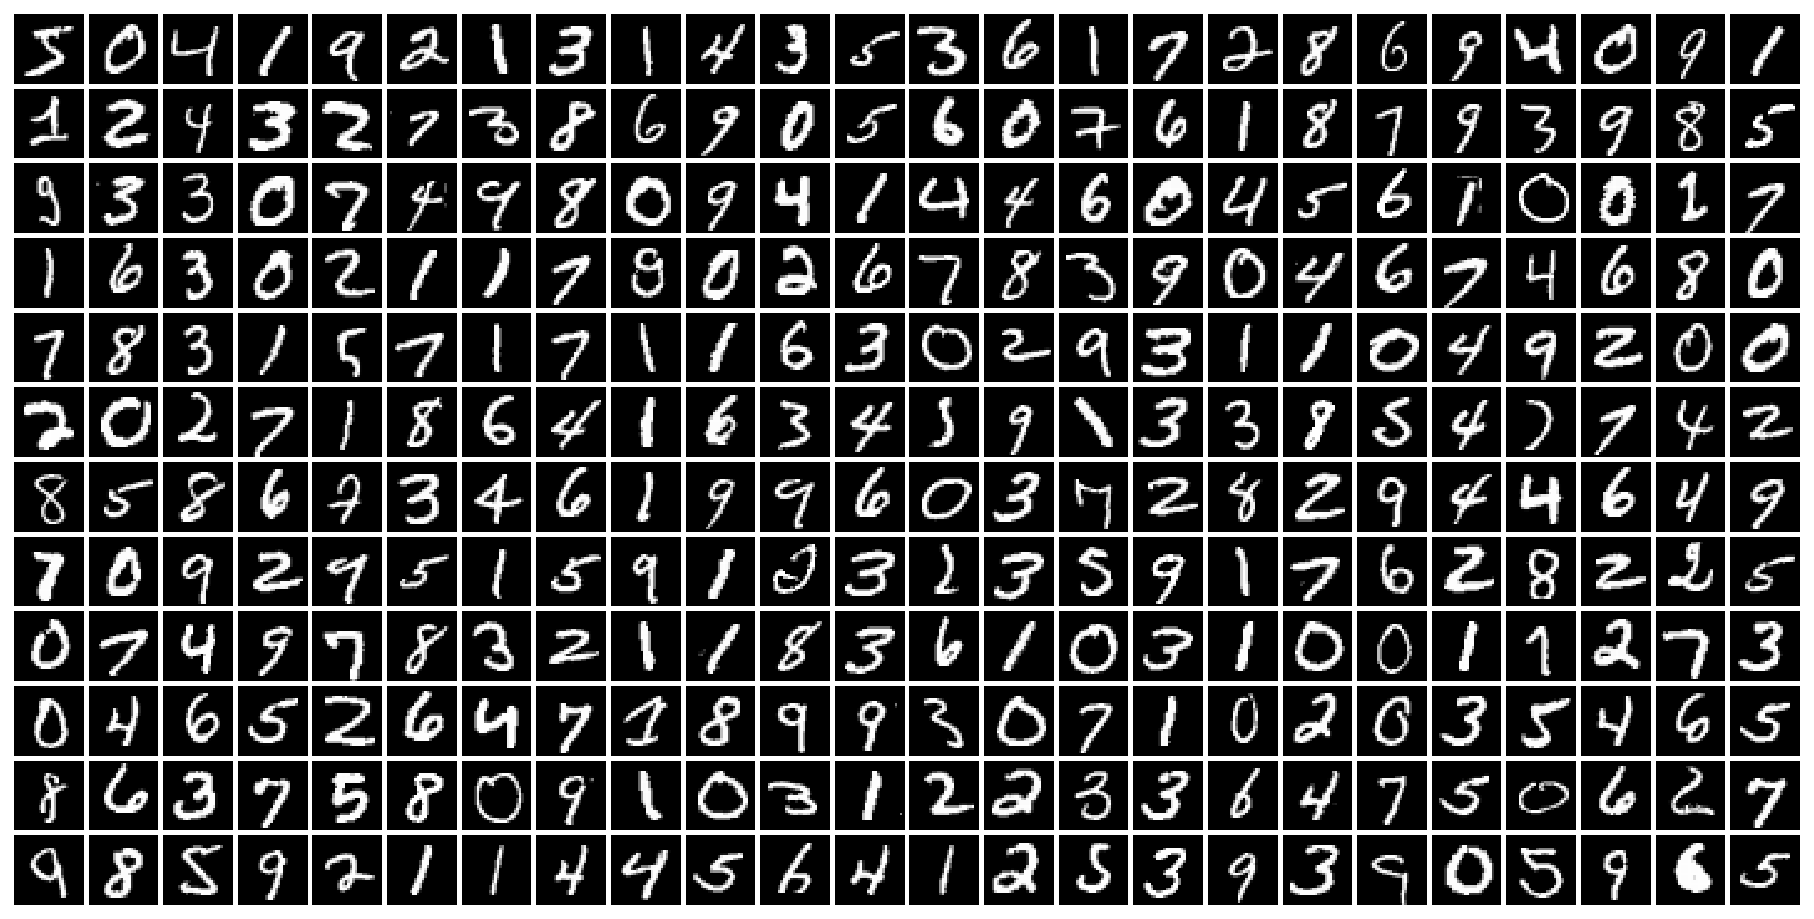

In [4]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# Restricted Boltzmann Machine & Contrastive Divergence algorithm

In [5]:
def sigmoid(matrix):
    return 1.0 / (1.0 + np.exp(-matrix))

class Rbm:
    def __init__(self, visible_size, hidden_size, learning_rate, pc_count = None):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.pc_count = pc_count
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size+1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0
        self.PC = None if self.pc_count is None else append_ones(zeros(self.pc_count, self.hidden_size))

In [6]:
def reconstuction_error(rbm, minibatch):
    observations_count = minibatch.shape[0]
    visible = zeros(observations_count, rbm.visible_size)
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    hidden[:, :-1] = sigmoid(minibatch @ rbm.W[:, :-1]) > rand(hidden.shape[0], hidden.shape[1] - 1)
    visible = sigmoid(hidden @ rbm.W[:-1, :].T)

    error = np.sum((minibatch[:, :-1] - visible) ** 2) / observations_count

    return error

## Algorytm Contrastive Divergence

$\newcommand{\vect}[1]{\mathbf{#1}}$
W sieci RBM gradient funkcji kosztu względem wag wyznaczamy zgodnie ze wzorem:

$\frac{\delta}{\delta w_{ij}} -\log P(\vect{v}) = -\mathbf{E}[v_i h_j \vert \vect{v}] + \mathbf{E}[v_i h_j]$

#### Faza pozytywna - odpowiada za część $\mathbf{E}[v_i h_j \vert \vect{v}]$

Tą część gradientu wyznaczamy przez wyliczenie iloczynów $v_i h_j$ pomiędzy elementami wektora obserwacji ($v_i$) a prawdopodobieństwami aktywacji w warstwie ukrytej ($h_j$). Operację tą możemy zapisać w postaci zwektoryzowanej jako:

$\nabla_P = \vect{v}^T\sigma(\vect{vW})$

#### Faza negatywna - odpowiada za część $\mathbf{E}[v_i h_j]$

Rozpoczynamy od prawdopodobieństw aktywacji neuronów w warstwie ukrytej, które zostały wyznaczone w fazie pozytywnej. Na ich podstawie losujemy próbkę aktywacji w warstwie ukrytej:

$\vect{h} = \sigma (\vect{vW}) > [rand_1, rand_2, \dots, rand_m]$

Następnie losujemy próbkę aktywacji w warstwie widocznej:

$\vect{v}_1 = \sigma (\vect{hW}^T) > [rand_1, rand_2, \dots, rand_n]$

Aby wyznaczyć *fantazję* sieci RBM, powyższe próbki losujemy (naprzemiennie) $k$ razy (gdzie $k$ to parametr algorytmu CD-*k*):

$\vect{h}_{k-1} = \sigma (\vect{v}_{k-1}\vect{W}) > [rand_1, rand_2, \dots, rand_m]$, 
$\vect{v}_k = \sigma (\vect{h}_{k-1}\vect{W}^T) > [rand_1, rand_2, \dots, rand_n]$

Część negatywną gradientu wyznaczamy poprzez wyliczenie iloczynów $v_{k_i} h_j$ pomiędzy elementami wektora *fantazji* RBM ($v_{k_i}$) a prawdopodobieństwami aktywacji w warstwie ukrytej wyliczonymi dla tejże *fantazji* ($h_j$). Operację tą możemy zapisać w postaci zwektoryzowanej jako:

$\nabla_N = \vect{v}_k^T\sigma(\vect{v}_k\vect{W})$


#### Aktualizacja macierzy wag RBM

Uczymy stochastycznym spadkiem wzdłuż gradientu:

$\phi_{t+1} \leftarrow \phi_t - \epsilon \nabla$

co dla gradientu RBM daje:

$W_{t+1} \leftarrow W_t + \epsilon \nabla_P - \epsilon \nabla_N$

In [7]:
def cdk(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    # POSITIVE PHASE
    positive_visible = minibatch
    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
    positive_phase_gradient = positive_visible.T @ positive_hidden

    # NEGATIVE PHASE
    negative_visible = append_ones(zeros(observations_count, rbm.visible_size))
    negative_hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    # sample hidden layer, get h_0 using input data
    negative_hidden[:, :-1] = positive_hidden[:, :-1] > rand(observations_count, rbm.hidden_size)

    # sample visible layer, get v_1
    negative_visible[:, :-1] = sigmoid(negative_hidden @ rbm.W[:-1, :].T) > rand(observations_count, rbm.visible_size)

    for _ in range(k - 1):
        # sample hidden layer, get h_{k - 1}, using v_{k - 1}
        negative_hidden[:, :-1] = sigmoid(negative_visible @ rbm.W[:, :-1]) > rand(observations_count, rbm.hidden_size)

        # sample hidden layer, get v_k, using h_{k - 1}
        negative_visible[:, :-1] = sigmoid(negative_hidden @ rbm.W[:-1, :].T) > rand(observations_count, rbm.visible_size)

    # NEGATIVE GRADIENT
    negative_hidden[:, :-1] = sigmoid(negative_visible @ rbm.W[:, :-1])
    negative_phase_gradient = negative_visible.T @ negative_hidden

    rbm.W = rbm.W + rbm.learning_rate * (positive_phase_gradient - negative_phase_gradient) / observations_count

## Algorytm Persistent Contrastive Divergence

$\newcommand{\vect}[1]{\mathbf{#1}}$
Algorytm Persistent Contrastive Divergence (PCD) różni się od algorytmu CD przebiegiem fazy negatywnej. Faza pozytywna przebiega w PCD tak samo jak w algorytmie CD.

W PCD faza negatywna rozpoczyna się od nie od przykładu uczącego, lecz od stanu *wirtualnych cząstek*, który został został zapamiętany w poprzedniej fazie negatywnej:

$\vect{h} = \vect{p}$,

gdzie $\vect{p}$ to macierz przechowująca stan *wirtualnych cząstek*. Po inicjalizacji negatywnego stanu ukrytego ($\vect{h}$) rozpoczynamy próbkowanie Gibbsa i wyznaczamy fantazję sieci ($\vect{v}_k$). Następnie zapamiętujemy nowy stan wirtualnych cząstek:

$\vect{p} = \sigma (\vect{v}_k\vect{W}) > [rand_1, rand_2, \dots, rand_m]$.

Na koniec aktualizujemy wagi RBM. Aktualizacja wag przebiega tak samo jak w algorytmie CD.

In [17]:
def pcd(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    # POSITIVE PHASE
    positive_visible = minibatch
    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
    positive_phase_gradient = positive_visible.T @ positive_hidden / observations_count

    # NEGATIVE PHASE
    negative_visible = append_ones(zeros(rbm.pc_count, rbm.visible_size))
    negative_hidden = append_ones(zeros(rbm.pc_count, rbm.hidden_size))

    # sample hidden layer, get h_0 using input data
    negative_hidden[:, :-1] = rbm.PC[:, :-1]

    # sample visible layer, get v_1
    negative_visible[:, :-1] = sigmoid(negative_hidden @ rbm.W[:-1, :].T) > rand(rbm.pc_count, rbm.visible_size)

    for _ in range(k - 1):
        # sample hidden layer, get h_{k - 1}, using v_{k - 1}
        negative_hidden[:, :-1] = sigmoid(negative_visible @ rbm.W[:, :-1]) > rand(rbm.pc_count, rbm.hidden_size)

        # sample hidden layer, get v_k, using h_{k - 1}
        negative_visible[:, :-1] = sigmoid(negative_hidden @ rbm.W[:-1, :].T) > rand(rbm.pc_count, rbm.visible_size)

    # NEGATIVE GRADIENT
    negative_hidden[:, :-1] = sigmoid(negative_visible @ rbm.W[:, :-1])
    negative_phase_gradient = (negative_visible.T @ negative_hidden) / rbm.pc_count

    rbm.PC[:, :-1] = negative_hidden[:, :-1] > rand(rbm.pc_count, rbm.hidden_size)

    rbm.W = rbm.W + rbm.learning_rate * (positive_phase_gradient - negative_phase_gradient)

# RBM Training

In [9]:
def sample_rbm(rbm, minibatch, steps):
    observations_count = minibatch.shape[0]

    visible = minibatch
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    
    for cd_i in range(steps):
        hidden[:, :-1] = sigmoid(visible @ rbm.W[:, :-1])
        hidden[:, :-1] = (hidden[:, :-1] > rand(observations_count, rbm.hidden_size)).astype(np.float32)
    
        visible[:, :-1] = sigmoid(hidden @ np.transpose(rbm.W[:-1, :]))
        if cd_i < (steps - 1):
            visible[:, :-1] = (visible[:, :-1] > rand(observations_count, rbm.visible_size)).astype(np.float32)

    return visible

In [10]:
def draw_filters(rbm):
    filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))
    tiles(filters)
    
def draw_samples(rbm, initial_batch, steps=200):
    tiles(np.reshape(sample_rbm(rbm, initial_batch, steps)[:, :-1], (-1, 24, 28, 28)))

In [11]:
def train_epoch(rbm, dataset, batch_size, training_algorithm=cdk):
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        training_algorithm(rbm, batch)
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

def run_training(rbm, dataset, monitoring_set, batch_size, epochs_count, training_algorithm=cdk):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch),  end="\t")

        start_time = time.time()
        train_epoch(rbm, dataset, batch_size, training_algorithm)

        elapsed = time.time() - start_time
        error = reconstuction_error(rbm, monitoring_set)
        print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

    print("Training finished!")

In [12]:
import time

DATASET_SIZE = 20000 # 60000 for whole dataset
DIGIT_SIZE = 28
BATCH_SIZE = 128
EPOCHS_COUNT = 50

VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128
LEARNING_RATE = 0.1

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = np.reshape(mnist_train[:DATASET_SIZE], newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

## CDK Training

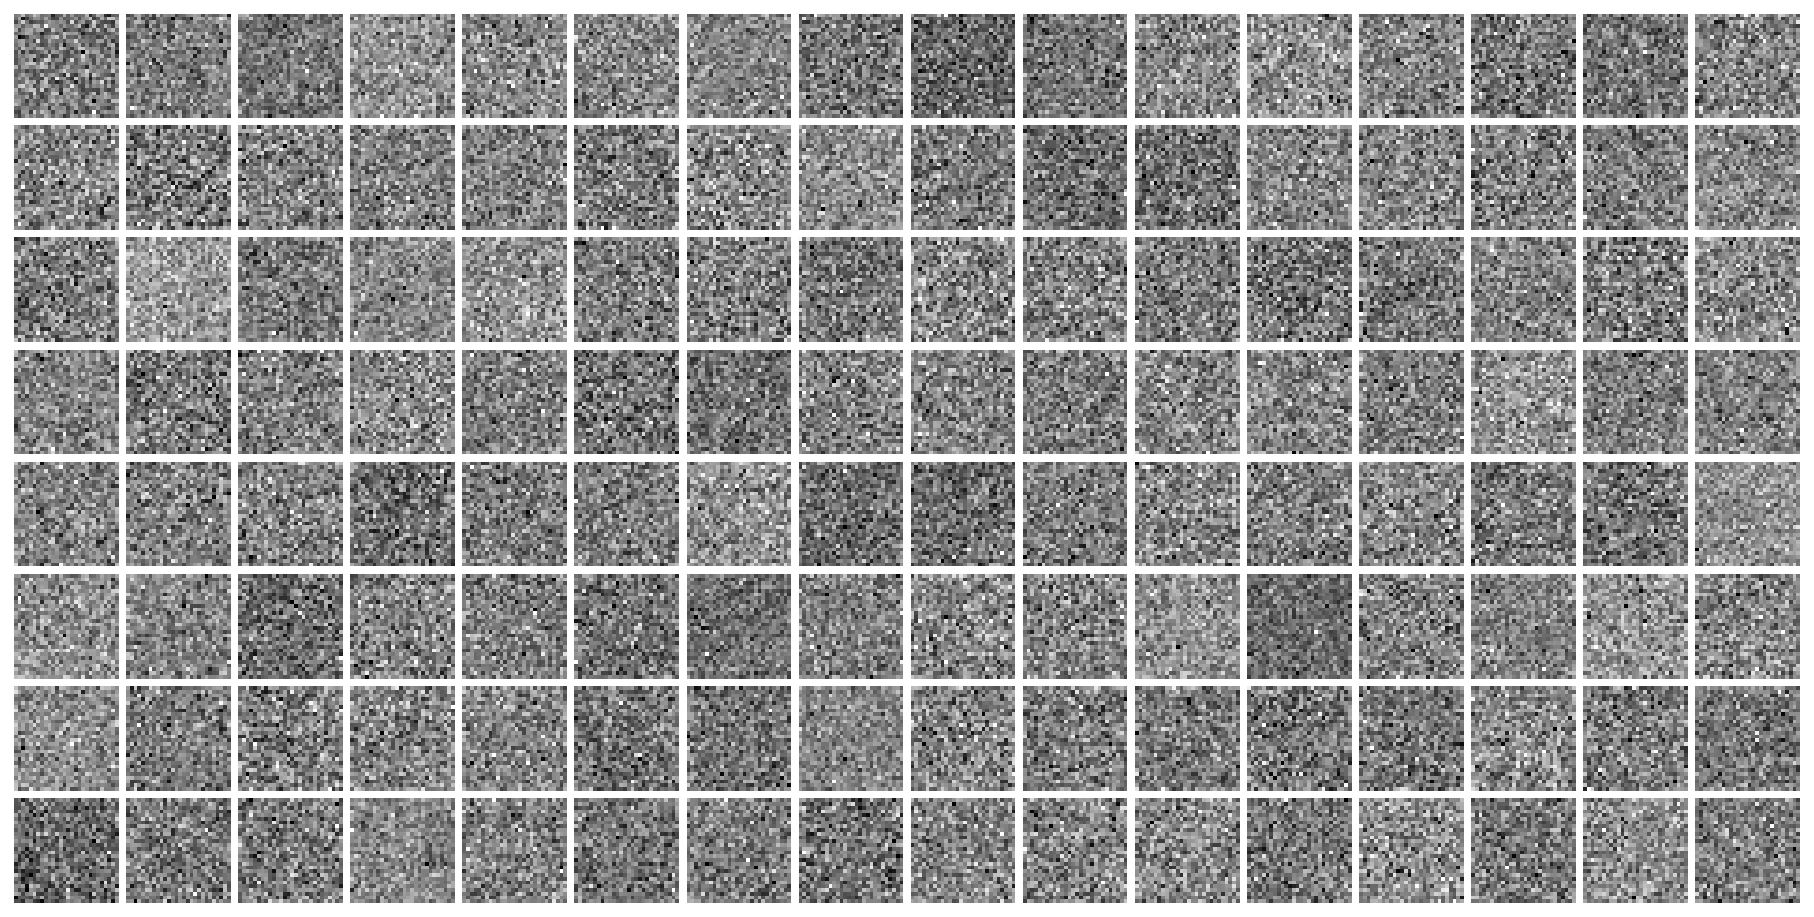

Epoch 0:	#####################################################	elapsed: 0.50s, reconstruction error: 32.25
Epoch 1:	#####################################################	elapsed: 0.50s, reconstruction error: 26.08
Epoch 2:	#####################################################	elapsed: 0.53s, reconstruction error: 22.67
Epoch 3:	#####################################################	elapsed: 0.48s, reconstruction error: 20.73
Epoch 4:	#####################################################	elapsed: 0.47s, reconstruction error: 19.21
Epoch 5:	#####################################################	elapsed: 0.40s, reconstruction error: 18.37
Epoch 6:	#####################################################	elapsed: 0.42s, reconstruction error: 17.39
Epoch 7:	#####################################################	elapsed: 0.44s, reconstruction error: 16.94
Epoch 8:	#####################################################	elapsed: 0.44s, reconstruction error: 16.37
Epoch 9:	############################

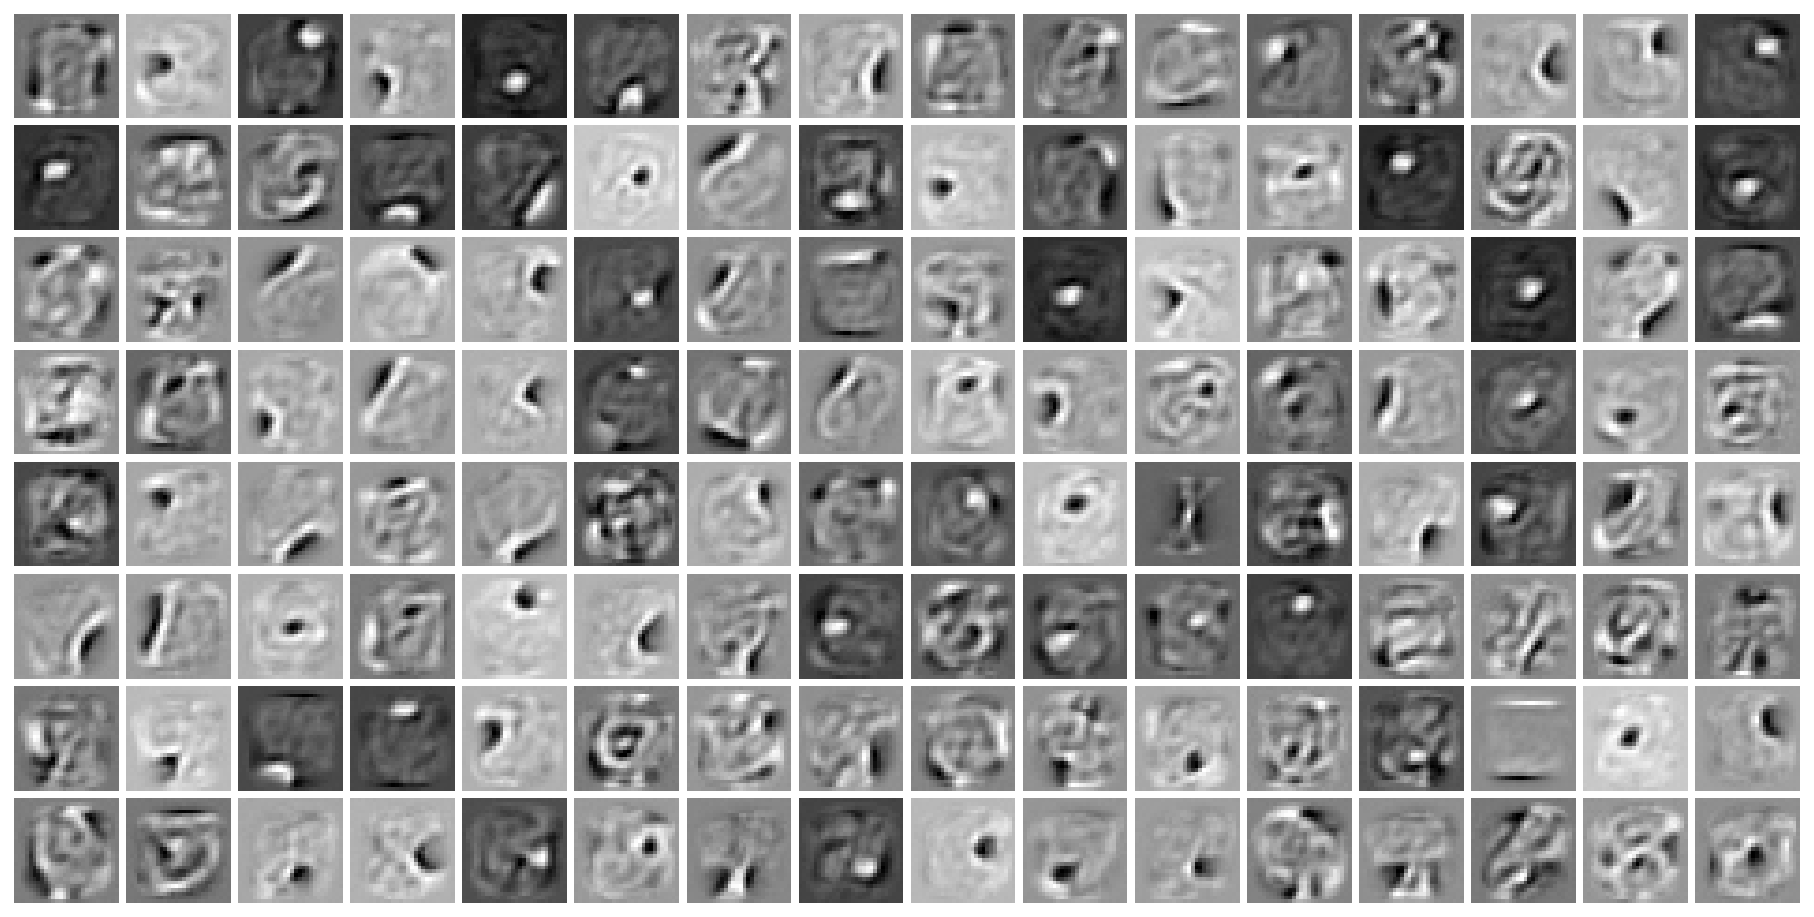

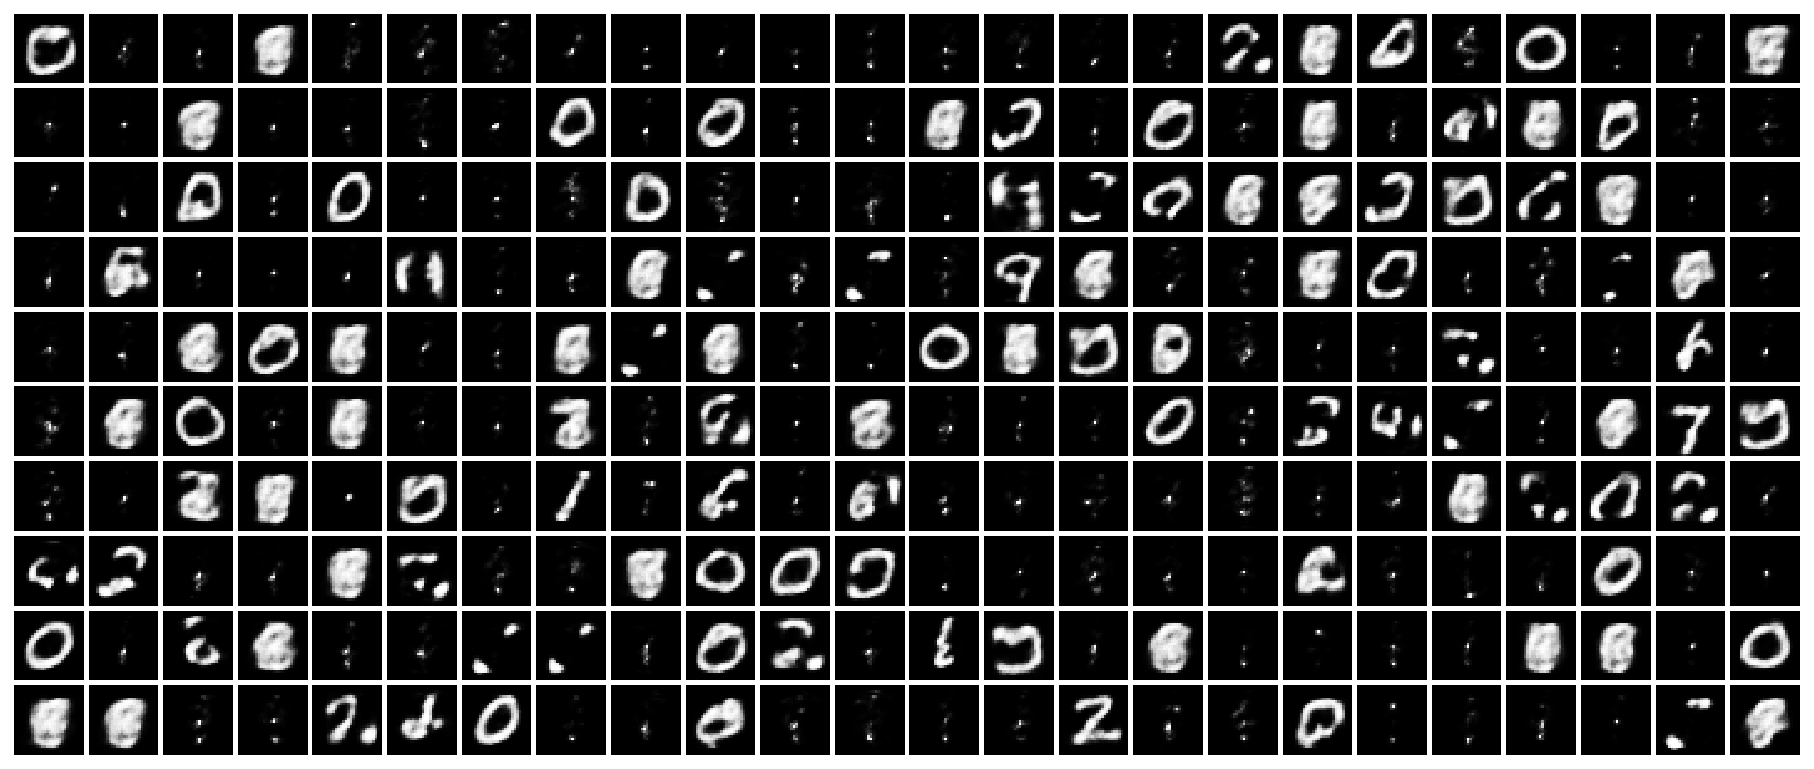

In [13]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

CDK_LEARNING_RATE = 0.1

rbm = Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, CDK_LEARNING_RATE)
draw_filters(rbm)

run_training(rbm, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT, cdk)

draw_filters(rbm)
draw_samples(rbm, monitoring_set[:10*24])

## PCD Training

(128, 129)


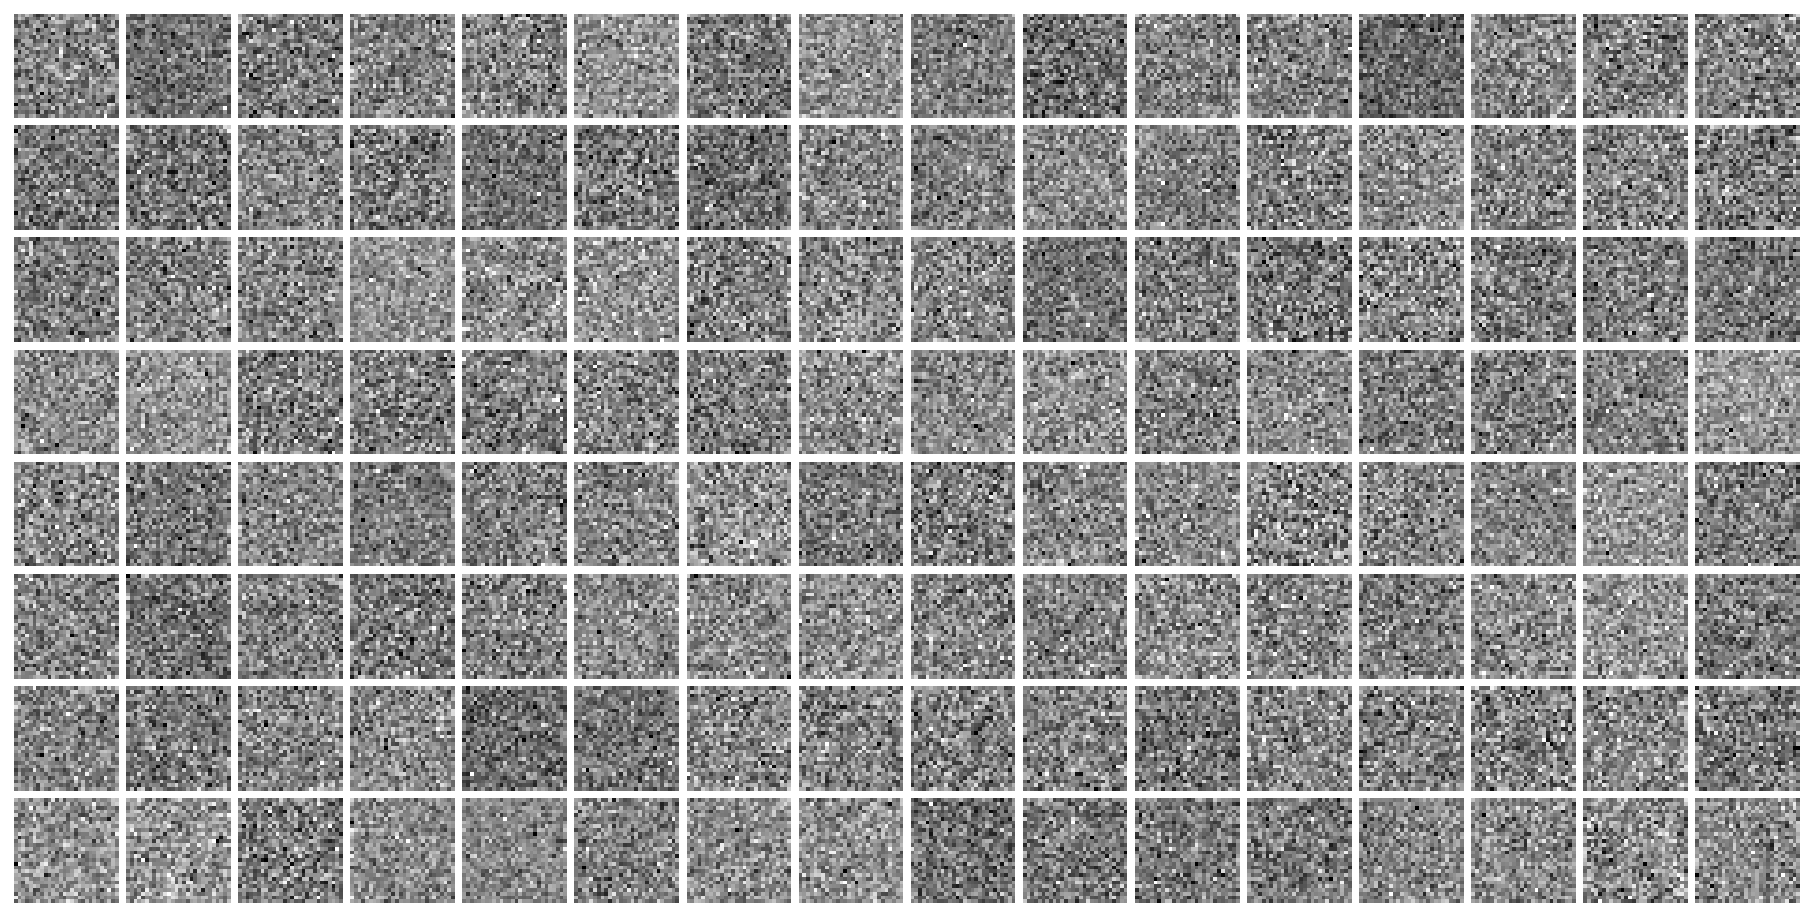

Epoch 0:	#####################################################	elapsed: 0.45s, reconstruction error: 57.74
Epoch 1:	#####################################################	elapsed: 0.40s, reconstruction error: 43.06
Epoch 2:	#####################################################	elapsed: 0.40s, reconstruction error: 26.84
Epoch 3:	#####################################################	elapsed: 0.38s, reconstruction error: 23.10
Epoch 4:	#####################################################	elapsed: 0.38s, reconstruction error: 19.37
Epoch 5:	#####################################################	elapsed: 0.37s, reconstruction error: 16.46
Epoch 6:	#####################################################	elapsed: 0.38s, reconstruction error: 14.59
Epoch 7:	#####################################################	elapsed: 0.37s, reconstruction error: 13.05
Epoch 8:	#####################################################	elapsed: 0.39s, reconstruction error: 11.77
Epoch 9:	############################

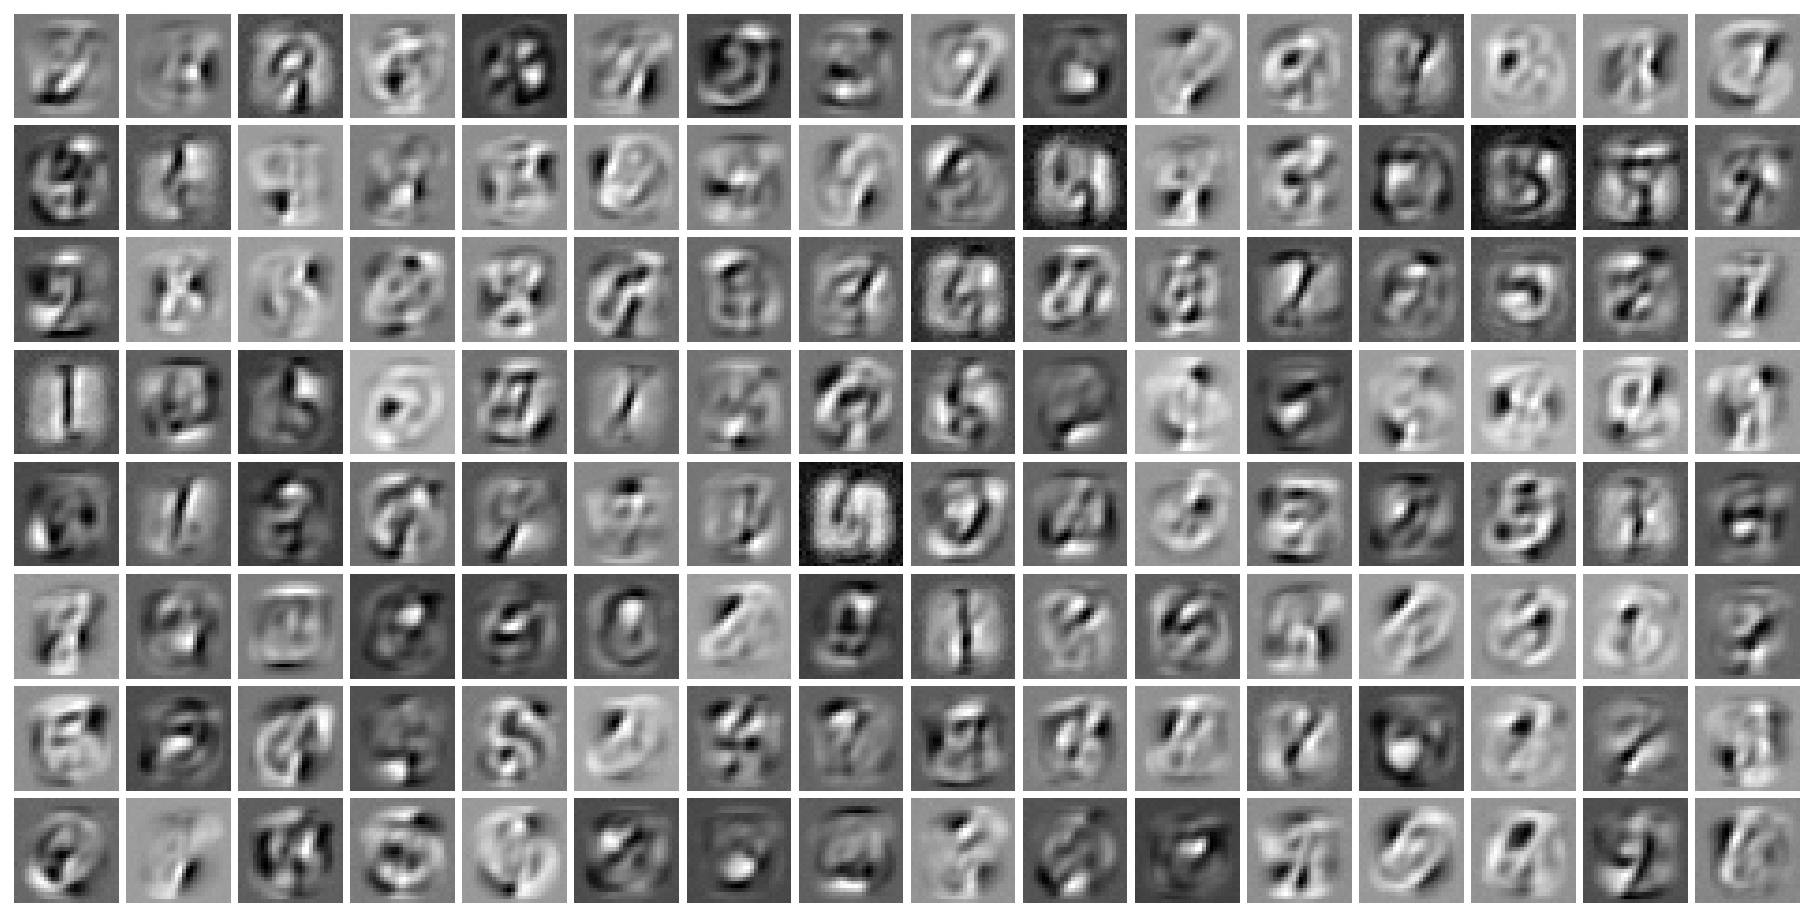

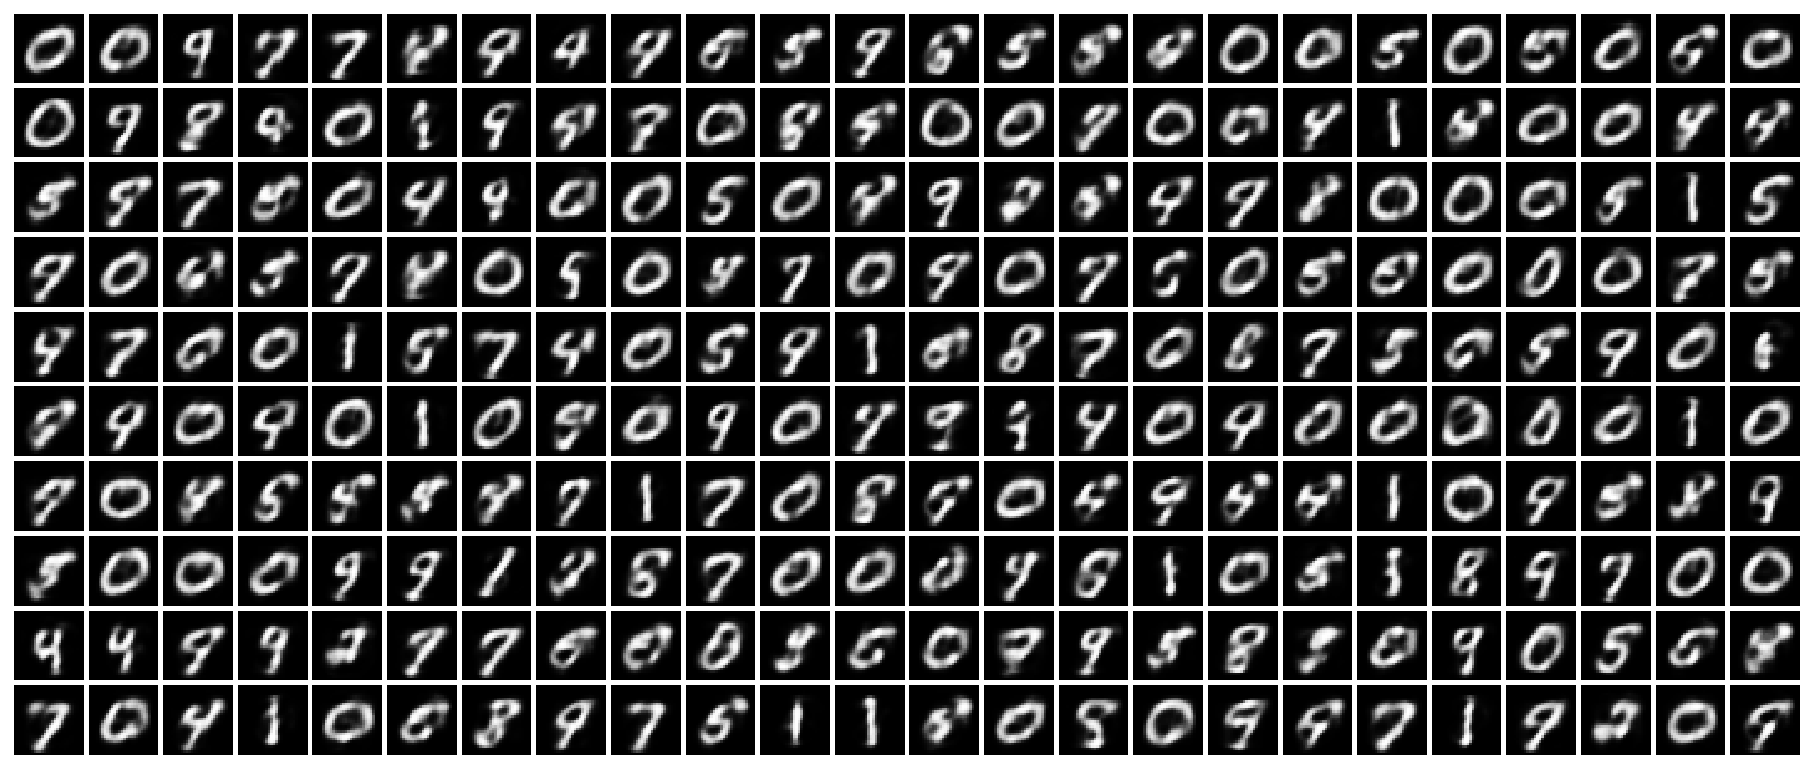

In [18]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

PCD_PARTICLES_COUNT = 128
PCD_LEARNING_RATE = 0.01

rbm_pcd = Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, PCD_LEARNING_RATE, PCD_PARTICLES_COUNT)
print(rbm_pcd.PC.shape)
draw_filters(rbm_pcd)

run_training(rbm_pcd, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT, pcd)

draw_filters(rbm_pcd)
draw_samples(rbm_pcd, monitoring_set[:10*24])